In [3]:

import sys
import os
import logging
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wget
from importlib import reload

import seaborn
import numpy as np
import pandas as pd
import pylab
import sklearn.preprocessing
import scipy.stats

import scgenome
import scgenome.dataimport
import scgenome.cncluster
import scgenome.cnplot

import dbclients.tantalus
from dbclients.basicclient import NotFoundError
import datamanagement.transfer_files

results_prefix = '/home/ubuntu/notebooks/results/htert/htert6'


In [4]:

import pickle
cn_data, metrics_data, image_feature_data = pickle.load(open(
    results_prefix + '_raw_data.pickle', 'rb'))
clusters, filter_metrics = recluster_df = pickle.load(open(
    results_prefix + '_clusters.pickle', 'rb'))
cell_clone_distances = pickle.load(open(
    results_prefix + '_cell_cluster_distances.pickle', 'rb'))


In [101]:

htert_data = pd.read_csv('htert_info.tsv', sep='\t')
metrics_data = metrics_data.merge(htert_data, on=['library_id', 'sample_id'])

htert_data.head()


,library_id,sample_id,description,cells_or_nuclei,spotter,passage,line,p53_null
0,A96225B,SA1101,184-hTERT 99.5 p10a from cryo,Cells,AR,p10a,a,0
1,A96162A,SA1101,184-hTERT 99.5 p15a from cryo,Cells,AR,p15a,a,0
2,A96155C,SA1101,184-hTERT 99.5 p20a from cryo,Cells,AR,p20a,a,0
3,A96240A,SA1101,184-hTERT 99.5 p25a from cryo,Cells,AR,p25a,a,0
4,A96225C,SA1101,184-hTERT 99.5 p30a from cryo,Cells,AR,p30a,a,0


/anaconda/envs/scgenome/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


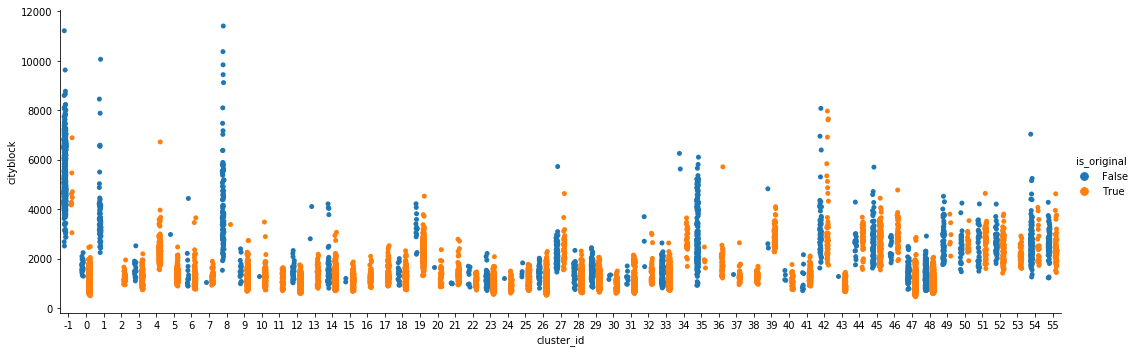

In [144]:

plot_data = cell_clone_distances.merge(clusters[['cell_id', 'cluster_id']])

correlation_metric = 'pearsonr'

correlation_cluster = (
    cell_clone_distances
    .set_index(['cluster_id', 'cell_id'])[correlation_metric]
    .unstack().idxmin().rename(correlation_metric + '_cluster_id').reset_index())

plot_data = plot_data.merge(correlation_cluster)
plot_data['is_original'] = (plot_data['cluster_id'] == plot_data[correlation_metric + '_cluster_id'])

plot_metric = 'cityblock'
seaborn.factorplot(
    x='cluster_id', y=plot_metric,
    hue='is_original', kind='strip',
    dodge=True, data=plot_data, aspect=3)


In [145]:

is_original_mean = plot_data.groupby('cluster_id')['is_original'].mean().rename('is_original_mean').reset_index()
is_original_mean['is_original_cluster_filter'] = is_original_mean['is_original_mean'] > 0.5
plot_data = plot_data.merge(is_original_mean)

cluster_df1 = clusters.merge(plot_data[['cell_id', 'is_original', 'is_original_cluster_filter']])
cluster_df1 = (cluster_df1
    .query('is_original')
    .query('is_original_cluster_filter')
)

cluster_df1 = cluster_df1.merge(
    cluster_df1.groupby('cluster_id').size().rename('cluster_size').reset_index())

cluster_df1 = cluster_df1.query('cluster_size > 50')


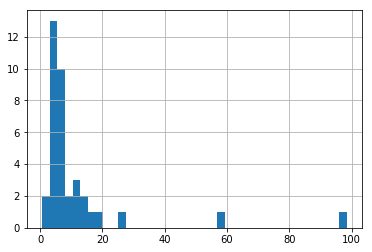

In [149]:

breakpoint_data = (
    metrics_data
    .merge(cluster_df1[['cell_id', 'cluster_id']])
    .groupby('cluster_id')['breakpoints']
    .mean().reset_index()
    .sort_values('breakpoints'))

filtered_clusters = breakpoint_data[
    (breakpoint_data['breakpoints'] < 20.)
]

cluster_df1 = cluster_df1.merge(filtered_clusters[['cluster_id']].drop_duplicates())

breakpoint_data['breakpoints'].hist(bins=40)


/anaconda/envs/scgenome/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


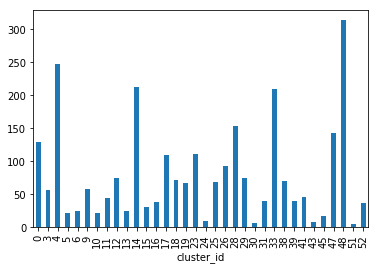

In [160]:

s_phase_data = cell_clone_distances.merge(
    metrics_data.query('is_s_phase')[['cell_id']])
s_phase_data = (
    s_phase_data
    .set_index(['cell_id', 'cluster_id'])['pearsonr']
    .unstack(level=['cluster_id']).idxmin(axis=1).rename('cluster_id').reset_index())
s_phase_data = s_phase_data.merge(
    cluster_df1[['cluster_id']].drop_duplicates())

s_phase_data.groupby('cluster_id').size().plot(kind='bar')

cluster_df = pd.concat([cluster_df1, s_phase_data], ignore_index=True)

assert not cluster_df['cell_id'].duplicated().any()


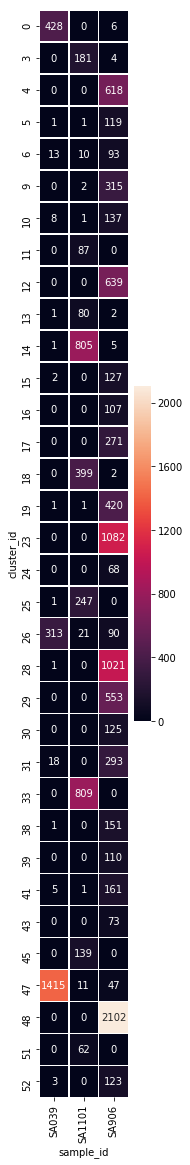

In [161]:

plot_data = (cluster_df
    .merge(metrics_data[['cell_id', 'sample_id']].drop_duplicates())
    .groupby(['cluster_id', 'sample_id']).size().unstack(fill_value=0).T)
plt.figure(figsize=(2, 20))
seaborn.heatmap(plot_data.T, annot=True, fmt="d", linewidths=.5)


/anaconda/envs/scgenome/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


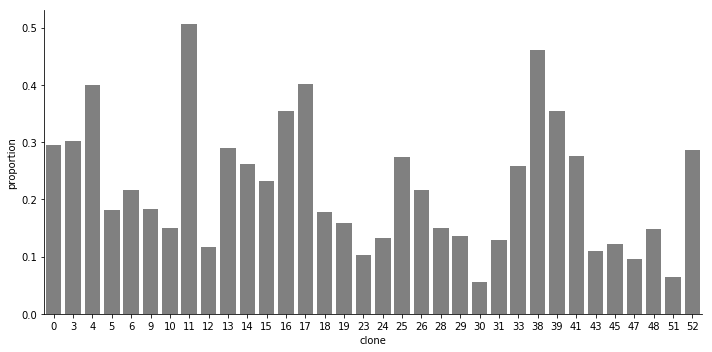

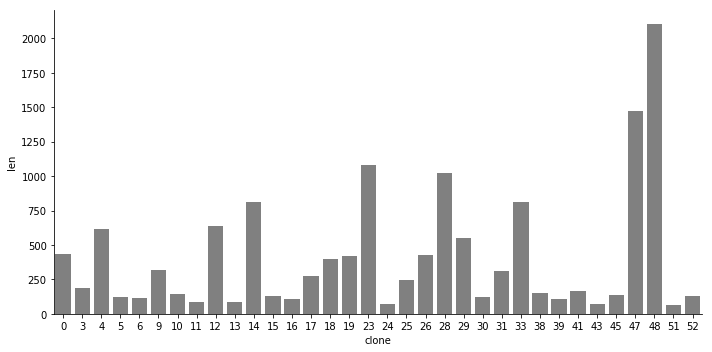

In [162]:

s_plot_data = (
    metrics_data
    .merge(cluster_df[['cell_id', 'cluster_id']].drop_duplicates())
    .groupby('cluster_id').agg({'is_s_phase': (np.sum, len, np.mean)}).reset_index())
s_plot_data.columns = ['clone', 'sum', 'len', 'proportion']

seaborn.factorplot(x='clone', y='proportion', kind='bar', data=s_plot_data, color='0.5', aspect=2)
seaborn.factorplot(x='clone', y='len', kind='bar', data=s_plot_data, color='0.5', aspect=2)


In [163]:

image_feature_data.loc[
    (image_feature_data['library_id'] == "A90600C"), 'spotter'] = 'deckard'

image_feature_data.groupby(['library_id', 'spotter'])['Diameter'].mean().reset_index().sort_values('Diameter')


,library_id,spotter,Diameter
25,A96210C,rachael,16.292949
33,A96240B,rachael,17.069295
12,A96163B,rachael,17.445302
24,A96199B,rachael,17.571856
31,A96233B,rachael,17.656722
30,A96228B,rachael,17.925352
18,A96183C,rachael,18.025774
29,A96226B,rachael,18.085903
7,A96146A,rachael,18.280583
32,A96240A,rachael,18.431953


/anaconda/envs/scgenome/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


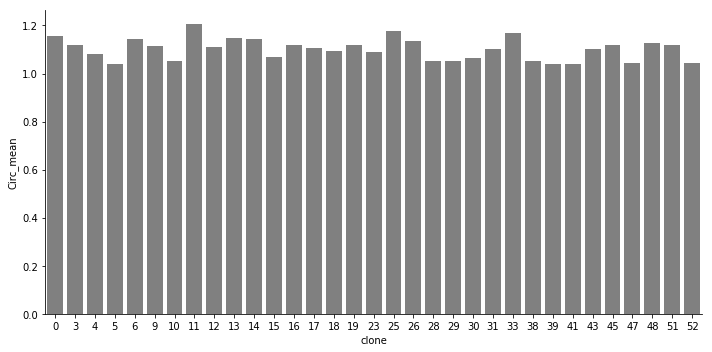

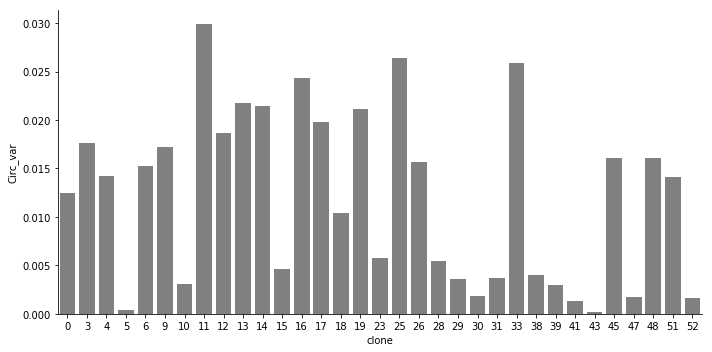

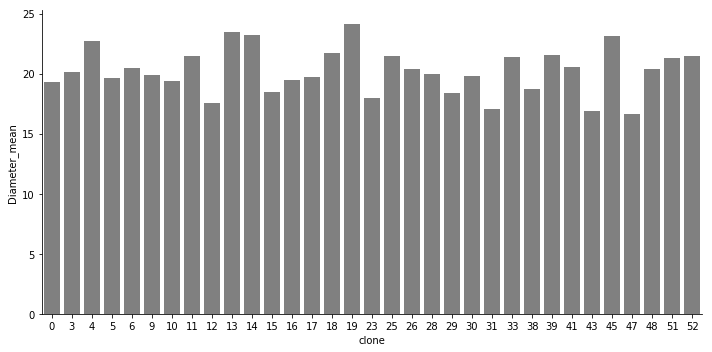

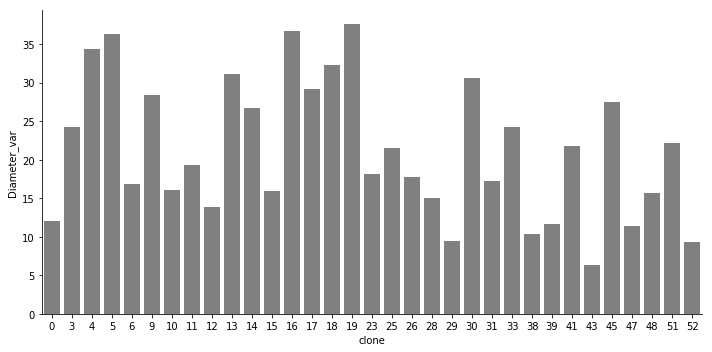

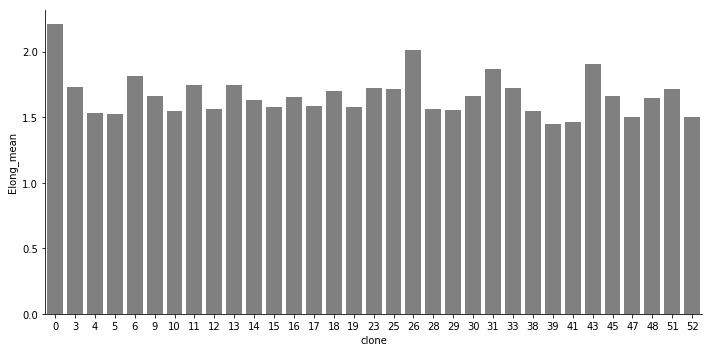

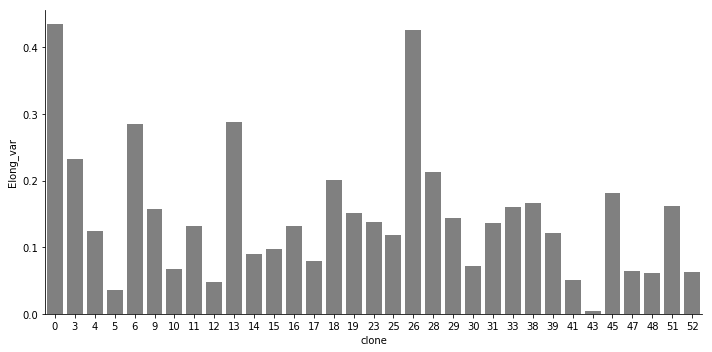

In [164]:

cluster_df['brief_cell_id'] = cluster_df['cell_id'].apply(lambda a: a.split('-', 1)[1])

image_plot_data = (
    image_feature_data
    .query('spotter == "rachael"')
    .query('library_id != "A90600C"')
    .merge(cluster_df[['brief_cell_id', 'cluster_id']])
    .groupby('cluster_id').agg({
        'Circ': (np.mean, np.var),
        'Diameter': (np.mean, np.var),
        'Elong': (np.mean, np.var),
    }))
image_plot_data.columns = ['_'.join(a) for a in image_plot_data.columns]
image_plot_data.index.name = 'clone'
image_plot_data = image_plot_data.reset_index()


seaborn.factorplot(x='clone', y='Circ_mean', kind='bar', data=image_plot_data, color='0.5', aspect=2)
seaborn.factorplot(x='clone', y='Circ_var', kind='bar', data=image_plot_data, color='0.5', aspect=2)
seaborn.factorplot(x='clone', y='Diameter_mean', kind='bar', data=image_plot_data, color='0.5', aspect=2)
seaborn.factorplot(x='clone', y='Diameter_var', kind='bar', data=image_plot_data, color='0.5', aspect=2)
seaborn.factorplot(x='clone', y='Elong_mean', kind='bar', data=image_plot_data, color='0.5', aspect=2)
seaborn.factorplot(x='clone', y='Elong_var', kind='bar', data=image_plot_data, color='0.5', aspect=2)


/home/ubuntu/notebooks/scgenome/scgenome/cnplot.py:125: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method='complete')
/anaconda/envs/scgenome/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


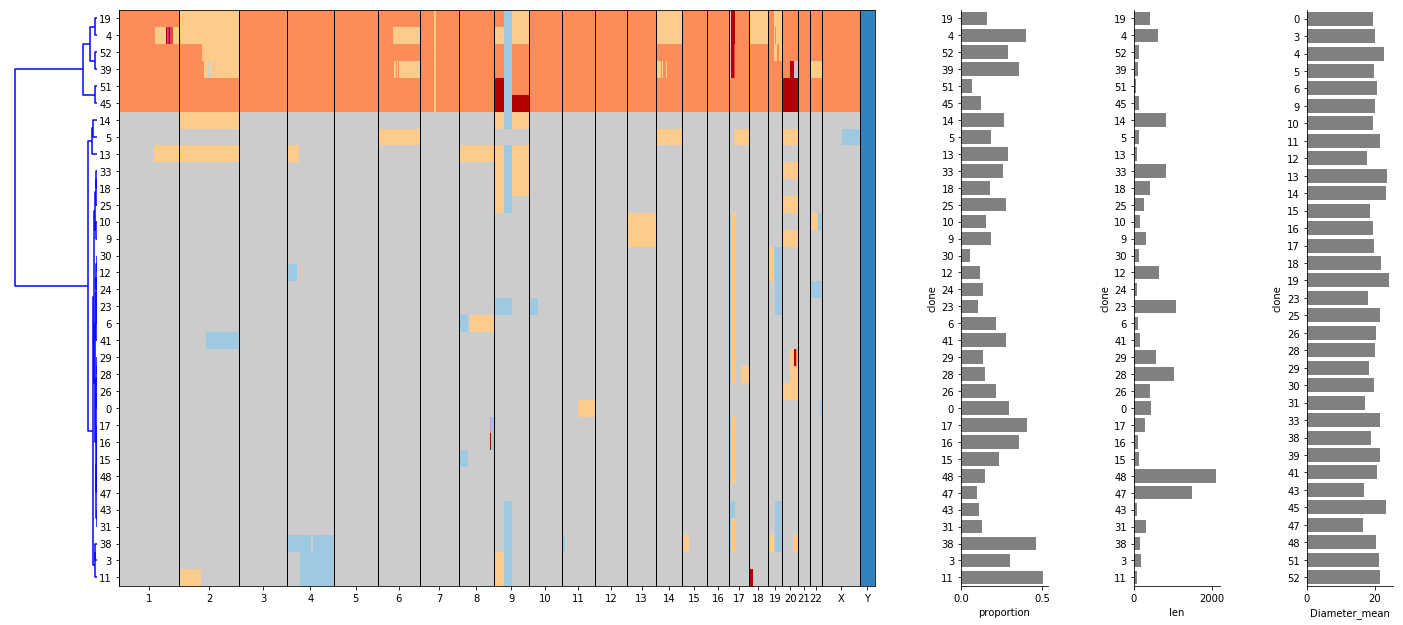

In [168]:

plot_data = cn_data.merge(cluster_df[['cell_id', 'cluster_id']].drop_duplicates())

import scgenome.cnplot
scgenome.cnplot = reload(scgenome.cnplot)

fig = plt.figure(figsize=(12, 8))
cluster_order = scgenome.cnplot.plot_cluster_cn_matrix(
    fig, plot_data, 'state', cluster_field_name='cluster_id')

ax = fig.add_axes([1.1,1.,0.1,1.])
seaborn.barplot(y='clone', x='proportion', data=s_plot_data, orient='h', color='0.5', order=cluster_order)
seaborn.despine(ax=ax)

ax = fig.add_axes([1.3,1.,0.1,1.])
seaborn.barplot(ax=ax, y='clone', x='len', data=s_plot_data, orient='h', color='0.5', order=cluster_order)
seaborn.despine(ax=ax)

ax = fig.add_axes([1.5,1.,0.1,1.])
seaborn.barplot(ax=ax, y='clone', x='Diameter_mean', data=image_plot_data, orient='h', color='0.5')
seaborn.despine(ax=ax)

plt.tight_layout()


In [169]:

fig.savefig('hterts.pdf', bbox_inches='tight')
